In [17]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

import missingno as msno
import matplotlib.pyplot as plt


In [3]:
import os

train=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')
submission=pd.read_csv('data/sample_submission.csv')

# 데이터 살펴보기

In [4]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [6]:
test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [7]:
train.shape

(26457, 20)

In [10]:
test.shape

(10000, 19)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

# 데이터 전처리
### train데이터에 해준 그대로 test데이터 전처리

### 1. 결측치 제거

In [9]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [10]:
#FLAG_MOBIL :  핸드폰 소유 여부 (1=있다 0=없다) 열은 모두 1의 값 --> 제거
train=train.drop('FLAG_MOBIL', axis=1)
test=test.drop('FLAG_MOBIL', axis=1)

## 민엽님이 작성한 5월 2일 코드 가져옴

In [12]:
#train데이터와 test 데이터합치기
data = pd.concat([train, test], axis=0)

In [21]:
data.isnull().sum()

index                0
gender               0
car                  0
reality              0
child_num            0
income_total         0
income_type          0
edu_type             0
family_type          0
house_type           0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
work_phone           0
phone                0
email                0
occyp_type       11323
family_size          0
begin_month          0
credit           10000
dtype: int64

<AxesSubplot:>

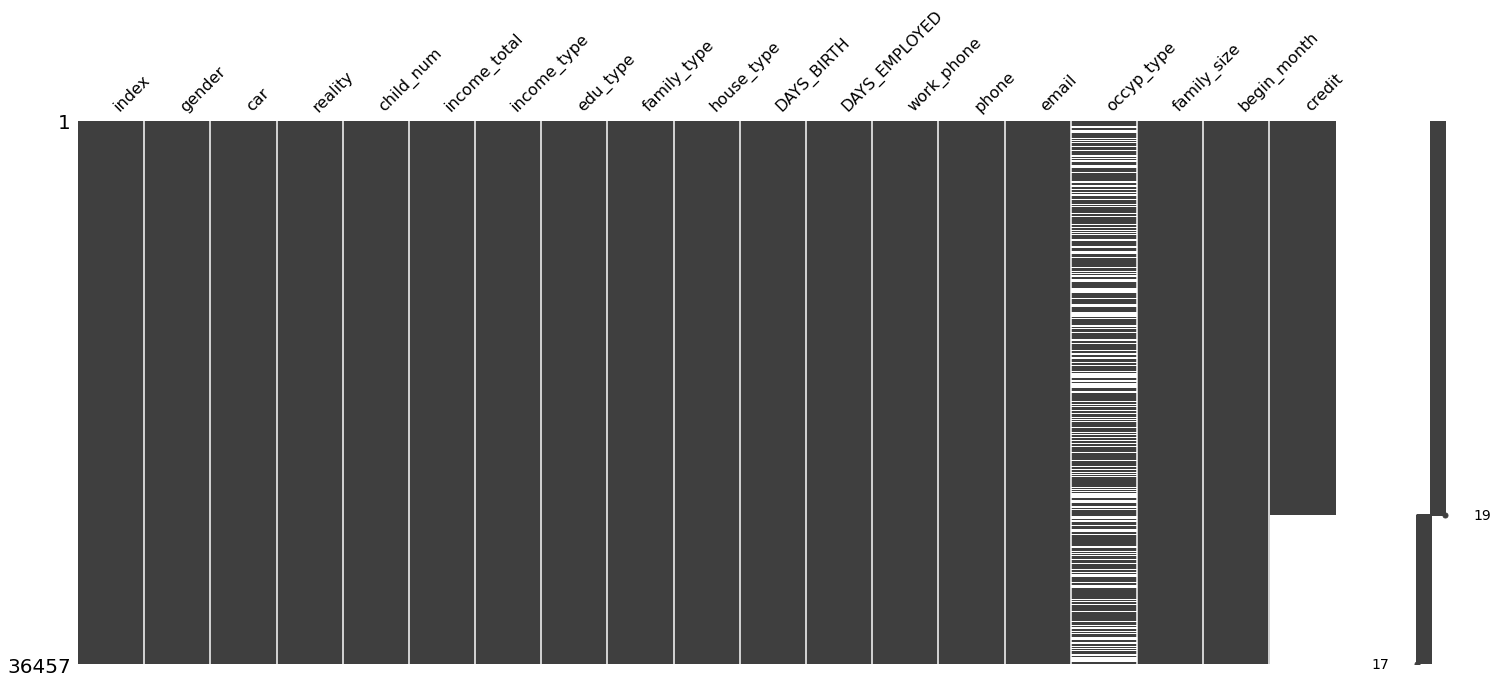

In [19]:
#결측치 시각화
%matplotlib inline
msno.matrix(data)

In [23]:
#컬럼별 그룹 나누기
len(data['gender'].unique())

2

In [25]:
#데이터 모든 컬럼의 unique값 찾기
unique_len=data.apply(lambda x: len(x.unique()))
unique_len

index            36457
gender               2
car                  2
reality              2
child_num            9
income_total       265
income_type          5
edu_type             5
family_type          5
house_type           6
DAYS_BIRTH        7183
DAYS_EMPLOYED     3640
work_phone           2
phone                2
email                2
occyp_type          19
family_size         10
begin_month         61
credit               4
dtype: int64

#2개 이하
#2개 초과 10개 이하
#10개초과
#세개 그룹으로 나누기

In [29]:
group_1=unique_len[unique_len<=2].index
group_1
#요소가 2개 이하인 그룹들의 컬럼

Index(['gender', 'car', 'reality', 'work_phone', 'phone', 'email'], dtype='object')

In [28]:
group_2=unique_len[(unique_len>2)&(unique_len<=10)].index
group_2

Index(['child_num', 'income_type', 'edu_type', 'family_type', 'house_type',
       'family_size', 'credit'],
      dtype='object')

In [30]:
group_3 = unique_len[(unique_len>10)].index
group_3

Index(['index', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'occyp_type',
       'begin_month'],
      dtype='object')

In [31]:
data[group_1]
#문자로 된데이터컬럼은 모델 학습에 바로 적용할 수 없음->0또는 1로 변경

,gender,car,reality,work_phone,phone,email
0,F,N,N,0,0,0
1,F,N,Y,0,0,1
2,M,Y,Y,0,1,0
3,F,N,Y,0,1,0
4,F,Y,Y,0,0,0
...,...,...,...,...,...,...
9995,F,Y,Y,1,1,0
9996,M,Y,Y,1,0,0
9997,F,N,Y,0,0,0
9998,F,Y,N,0,1,0


In [33]:
data['gender']=data['gender'].replace(['F', 'M'], [0, 1])

In [34]:
#car와 reality에도 적용
data['car'] = data['car'].replace(['N', 'Y'], [0,1])
data['reality'] = data['reality'].replace(['N', 'Y'], [0,1])

In [36]:
#group2에 해당하는 컬럼만추출
data[group_2]
#credit은 예측값이니까 이거 빼고 전처리 하기

,child_num,income_type,edu_type,family_type,house_type,family_size,credit
0,0,Commercial associate,Higher education,Married,Municipal apartment,2.0,1.0
1,1,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,3.0,1.0
2,0,Working,Higher education,Married,House / apartment,2.0,2.0
3,0,Commercial associate,Secondary / secondary special,Married,House / apartment,2.0,0.0
4,0,State servant,Higher education,Married,House / apartment,2.0,2.0
...,...,...,...,...,...,...,...
9995,0,Working,Incomplete higher,Married,House / apartment,2.0,NaN
9996,0,Working,Secondary / secondary special,Civil marriage,House / apartment,2.0,NaN
9997,0,Working,Secondary / secondary special,Married,House / apartment,2.0,NaN
9998,0,Commercial associate,Secondary / secondary special,Married,House / apartment,2.0,NaN


<AxesSubplot:>

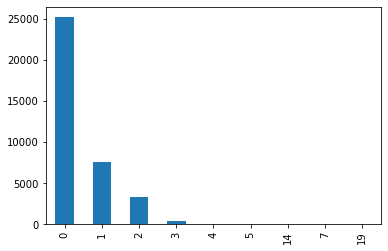

In [38]:
data['child_num'].value_counts().plot.bar()
#0이 대부분이고 3부터 19까지는 값이 거의 존재하지 않음

In [41]:
data.loc[data['child_num']>2, 'child_num']=2
#child_num이 2보다 큰 애들에 접근하기
#해당 값들 2로 바꿔주기

<AxesSubplot:>

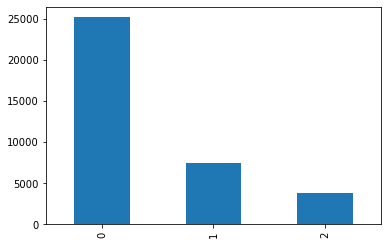

In [43]:
data['child_num'].value_counts().plot.bar()

In [45]:
data[group_2].apply(lambda x : len(x.unique()))
#많으면 10개까지의 데이터 값을 가진 것을 알 수 있음
#일일이인코딩하기 번거로움->싸이킷런이용

child_num       3
income_type     5
edu_type        5
family_type     5
house_type      6
family_size    10
credit          4
dtype: int64

In [46]:
from sklearn import preprocessing

In [47]:
label_encoder = preprocessing.LabelEncoder()

In [50]:
data['income_type'].unique()

array(['Commercial associate', 'Working', 'State servant', 'Pensioner',
       'Student'], dtype=object)

<AxesSubplot:>

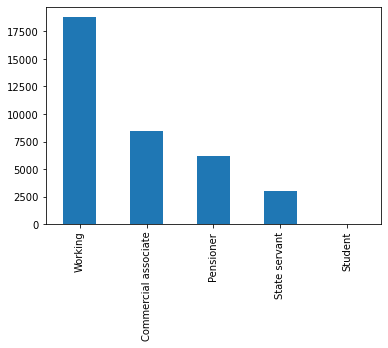

In [51]:
data['income_type'].value_counts().plot.bar()
#student값 거의 존재하지않음

In [52]:
set(label_encoder.fit_transform(data['income_type']))

{0, 1, 2, 3, 4}

In [53]:
data['income_type'] = set(label_encoder.fit_transform(data['income_type']))
data['edu_type'] = set(label_encoder.fit_transform(data['edu_type']))
data['family_type'] = set(label_encoder.fit_transform(data['income_type']))
data['income_type'] = set(label_encoder.fit_transform(data['income_type']))

ValueError: Length of values (5) does not match length of index (36457)

In [48]:
label_encoder.fit_transform()

TypeError: fit_transform() missing 1 required positional argument: 'y'

In [35]:
data[group_1]

,gender,car,reality,work_phone,phone,email
0,0,0,0,0,0,0
1,0,0,1,0,0,1
2,1,1,1,0,1,0
3,0,0,1,0,1,0
4,0,1,1,0,0,0
...,...,...,...,...,...,...
9995,0,1,1,1,1,0
9996,1,1,1,1,0,0
9997,0,0,1,0,0,0
9998,0,1,0,0,1,0


In [ ]:

df[~((df['occyp_type'].isnull()) & (df['DAYS_EMPLOYED'] < 0))]
df['occyp_type'] = df['occyp_type'].fillna(0)
df['gender'].replace({'M':0,'F':1}, inplace=True)
df['car'].replace({'N':0,'Y':1}, inplace=True)
df['reality'].replace({'N':0,'Y':1}, inplace=True)

### Binary variables
### 0, 1

In [15]:
train['gender']=train['gender'].replace(['F','M'],[0,1])
test['gender']=test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('-------------')

gender :
0    17697
1     8760
Name: gender, dtype: int64
-------------


In [17]:
print('Having a car or not: ')
train['car']=train['car'].replace(['N','Y'],[0,1])
test['car']=test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

Having a car or not: 
0    16410
1    10047
Name: car, dtype: int64
--------------


In [18]:
print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N', 'Y'], [0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('-------------')

print('Having a phone or not: ')
print(train['phone'].value_counts())
print('----------')

print('Having a email or not: ')
print(train['email'].value_counts())
print('---------------')

print('Having a work phone or not:')
print(train['work_phone'].value_counts())
print('-------------')

Having house reality or not: 
1    17830
0     8627
Name: reality, dtype: int64
-------------
Having a phone or not: 
0    18672
1     7785
Name: phone, dtype: int64
----------
Having a email or not: 
0    24042
1     2415
Name: email, dtype: int64
---------------
Having a work phone or not:
0    20511
1     5946
Name: work_phone, dtype: int64
-------------


## 3. Continuous variable
#### (1)child_num

<AxesSubplot:>

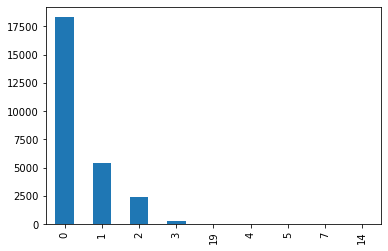

In [19]:
train['child_num'].value_counts(sort=False).plot.bar()

In [20]:
train.loc[train['child_num']>=2, 'child_num']=2
test.loc[test['child_num']>=2, 'child_num']=2

(2.544, 18.18]      16212
(18.18, 33.66]       8330
(33.66, 49.14]       1530
(49.14, 64.62]        206
(64.62, 80.1]         121
(80.1, 95.58]          44
(95.58, 111.06]         3
(111.06, 126.54]        2
(126.54, 142.02]        4
(142.02, 157.5]         5
Name: income_total, dtype: int64


<AxesSubplot:ylabel='Frequency'>

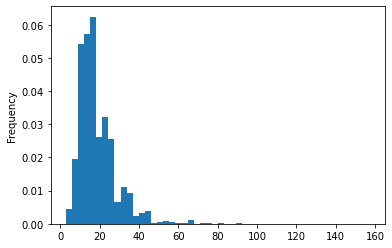

In [21]:
train['income_total'] = train['income_total'].astype(object)
train['income_total'] = train['income_total']/10000
test['income_total'] = test['income_total']/10000

print(train['income_total'].value_counts(bins=10, sort=False))
train['income_total'].plot(kind='hist', bins=50, density=True)

In [ ]:
count, bin_dividers = np.histogram(train['income_total'], bins=7)
bin_names=['소득'+str(i) for i in range(7)]
#bin_drivers는 train 기준
train['income_total']=pd.cut(x=train['income_total', bins=bin_drivers, labels=bin_names, inclue_lowest=True])
test

In [ ]:
## 1. 결측치 제거

In [2]:
import os
import getpass

username=getpass.getuser()
username

'유진아'